<a href="https://colab.research.google.com/github/mehdi-or/VT2PFC/blob/main/Alternating_DATRACE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

Mounted at /content/gdrive


## Function for setting seed for reproducility

In [3]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # Numpy module
    torch.manual_seed(seed_value)  # PyTorch random number generator for CPU

    # If you are using CUDA
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

    # Additional configurations to enhance reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## My Implimentation of DATRACE (VT2PF)

In [ ]:
class DATRACE(nn.Module):
    def __init__(self, input_size_VT, input_size_PF, hidden_size, bottleneck_size, num_classes):
        super(DATRACE, self).__init__()
        # Encoder
        self.VT_in = nn.Linear(input_size_VT, hidden_size)
        self.PF_in = nn.Linear(input_size_PF, hidden_size)
        self.fc2 = nn.Linear(hidden_size, bottleneck_size)

        # Decoder
        self.fc3 = nn.Linear(bottleneck_size, hidden_size)
        self.PF_out = nn.Linear(hidden_size, input_size_PF)
        self.VT_out = nn.Linear(hidden_size, input_size_VT)

        # Classifier connected to the bottleneck
        self.classifier = nn.Linear(bottleneck_size, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x1, x2):
        # Encoder 1
        x1 = torch.tanh(self.VT_in(x1))
        x1 = self.dropout(x1)
        encoded = torch.tanh(self.fc2(x1))

        #Encoder 2
        x2 = torch.tanh(self.VT_in(x2))
        x2 = self.dropout(x2)
        encoded = torch.tanh(self.fc2(x2)) # here the "encoded" is simply just overwritten by "fc2(x2)". This is a problem that requires to concatenate the ouput of fc2(x1) and fc2(x2)

        # Decoder 1
        x1 = torch.tanh(self.fc3(encoded))
        decoded_PF = self.PF_out(x1)

        # Decoder 2
        x2 = torch.tanh(self.fc3(encoded))
        decoded_VT = self.VT_out(x2)

        # Classifier
        logits = self.classifier(encoded)
        #probabilities = F.softmax(logits, dim=1)
        probabilities = logits

        return decoded_PF, decoded_VT, probabilities


# Example model instantiation
input_size_VT = 1500 # e.g., for MNIST
input_size_PF = 1000
hidden_size = 128
bottleneck_size = 32
num_classes = 10 # e.g., for MNIST classification

model = DATRACE(input_size_VT=input_size_VT, input_size_PF=input_size_PF, hidden_size=hidden_size,
                                  bottleneck_size=bottleneck_size, num_classes=num_classes)
print(model)


##Importing and preprocessing the data

In [4]:
def load_data_VTC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_VT_PETERS.hdf5', 'r') as hdf:
        data0 = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_vtc = np.array(data0)
        data_vtc = np.delete(data_vtc,np.where(~data_vtc.any(axis=0))[0],axis=1)
    return(data_vtc)

def load_data_PFC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_DLPFC_PETERS.hdf5', 'r') as hdf:
        data0_pfc = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_pfc = np.array(data0_pfc)
        data_pfc = np.delete(data_pfc,np.where(~data_pfc.any(axis=0))[0],axis=1)
    return(data_pfc)

def preprocessign (data, labels2categ, shuffle_index):
  data_train, data_test, y_categ_train, y_categ_test, map_train_index, map_test_index = train_test_split(data, labels2categ, shuffle_index, random_state=42)
  #scaler = StandardScaler()
  scaler = MinMaxScaler(feature_range=(-1,1))
  X_train = scaler.fit_transform(data_train)
  X_test = scaler.transform(data_test)
  return X_train, X_test, y_categ_train, y_categ_test, map_train_index, map_test_index

#setting the labels for pytorch is differen from keras
# the way it works is that we need to assign a number to each categorical class
unique_labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/unique_aranged.csv', header=None).values[:,1]
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/label.csv')['y'].values
label_to_index = {label: idx for idx, label in enumerate(unique_labels)} #mapping form label to its numeric value
index_to_label = {idx: label for label, idx in label_to_index.items()} #mapping from numeric label to the name of the label

#turning label file into its numeric values
numeric_labels = []
for label in labels:
  numeric_labels.append(label_to_index[label])

numeric_labels = np.array(numeric_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#converting all the numpy array inot pytorch tensor

VTC = load_data_VTC(37)
PFC = load_data_PFC(37)
shuffle_index = np.arange(0,3600)
VTC_train, VTC_test, y_train, y_test, map_train_index, map_test_index = preprocessign(VTC, numeric_labels, shuffle_index)
PFC_train, PFC_test, _, _, _, _ = preprocessign(PFC, numeric_labels, shuffle_index)

VTC_tensor_train = torch.tensor(VTC_train, dtype=torch.float32).to(device)
VTC_tensor_test = torch.tensor(VTC_test, dtype=torch.float32).to(device)

PFC_tensor_train = torch.tensor(PFC_train, dtype=torch.float32).to(device)
PFC_tensor_test = torch.tensor(PFC_test, dtype=torch.float32).to(device)

y_tensor_train = torch.tensor(y_train)
y_tensor_test =torch.tensor(y_test)

VTC_train_dataset = TensorDataset(VTC_tensor_train, y_tensor_train)
VTC_test_dataset = TensorDataset(VTC_tensor_test, y_tensor_test)

PFC_train_dataset = TensorDataset(PFC_tensor_train, y_tensor_train)
PFC_test_dataset = TensorDataset(PFC_tensor_test, y_tensor_test)

set_seed(42)
VTC_train_loader = DataLoader(VTC_train_dataset, batch_size=64, shuffle=True)
VTC_test_loader = DataLoader(VTC_train_dataset, batch_size=64, shuffle=False)

PFC_train_loader = DataLoader(PFC_train_dataset, batch_size=64, shuffle=True)
PFC_test_loader = DataLoader(PFC_train_dataset, batch_size=64, shuffle=False)

train_dataset = TensorDataset(VTC_tensor_train, PFC_tensor_train, y_tensor_train)
test_dataset = TensorDataset(VTC_tensor_test, PFC_tensor_test, y_tensor_test)
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
# 2. Define the model, optimizer, and loss functions
input_size_VT = VTC_train.shape[1]
input_size_PF = PFC_train.shape[1]
hidden_size = 500
bottleneck_size = 50
num_classes = len(unique_labels)

##GPT implementation of alternating architecture

In [5]:
class DATRACE(nn.Module):
    def __init__(self, input_dim_VT, input_dim_PF, hidden_dim, bottleneck_dim, num_classes, VT_update =True):
        super(DATRACE, self).__init__()
        # Encoding layers for the VTC
        self.encoder_a = nn.Linear(input_dim_VT, hidden_dim)
        # Encoding layers for PFC
        self.encoder_b = nn.Linear(input_dim_PF, hidden_dim)

        # Shared bottleneck layer
        self.shared_bottleneck = nn.Linear(hidden_dim, bottleneck_dim)  # Assume same dim for simplicity

        # Decoding layers for PFC
        self.decoder_a = nn.Linear(bottleneck_dim, hidden_dim)
        self.prediction_PF = nn.Linear(hidden_dim, input_dim_PF)

        # Decoding layers for VTC
        self.decoder_b = nn.Linear(bottleneck_dim, hidden_dim)
        self.prediction_VT = nn.Linear(hidden_dim, input_dim_VT)

        # Classification layer attached to the shared bottleneck
        self.classifier = nn.Linear(bottleneck_dim, num_classes)
    '''
    def forward_VT2PF(self, x_a):
        encoded_a = torch.tanh(self.encoder_a(x_a))
        bottleneck = torch.tanh(self.shared_bottleneck(encoded_a))
        decoded_a = torch.tanh(self.decoder_a(bottleneck))
        predicted_PF = self.prediction_PF(decoded_a)
        class_logits = self.classifier(bottleneck)
        return predicted_PF, class_logits

    def forward_PF2VT(self, x_b):
        encoded_b = torch.tanh(self.encoder_b(x_b))
        bottleneck = torch.tanh(self.shared_bottleneck(encoded_b))
        decoded_b = torch.tanh(self.decoder_b(bottleneck))
        predicted_VT = self.prediction_VT(decoded_b)
        class_logits = self.classifier(bottleneck)
        return predicted_VT, class_logits
    '''

    def forward(self, x_a, x_b, VT_update=True):
        encoded_a = torch.tanh(self.encoder_a(x_a))
        encoded_b = torch.tanh(self.encoder_b(x_b))
        if VT_update:
          bottleneck = torch.tanh(self.shared_bottleneck(encoded_a))
        else:
          bottleneck = torch.tanh(self.shared_bottleneck(encoded_b))
        decoded_a = torch.tanh(self.decoder_a(bottleneck))
        decoded_b = torch.tanh(self.decoder_b(bottleneck))
        predicted_PF = self.prediction_PF(decoded_a)
        predicted_VT = self.prediction_VT(decoded_b)
        class_logits = self.classifier(bottleneck)
        return predicted_PF, predicted_VT, class_logits

'''
# Example usage
input_dim_a = 784  # Example dimensions for different inputs
input_dim_b = 512
hidden_dim = 128  # Set equal for simplicity
bottleneck_dim = 32
num_classes = 10  # For multi-class classification

model = DATRACE(input_dim_a, input_dim_b, hidden_dim, bottleneck_dim, num_classes)

# Example inputs
x_a = torch.randn(10, input_dim_a)  # Batch of inputs for branch A
x_b = torch.randn(10, input_dim_b)  # Batch of inputs for branch B

# Forward passes
reconstructed_a, class_logits_a = model.forward_VT2PF(x_a)
reconstructed_b, class_logits_b = model.forward_PF2VT(x_b)

print(f"Reconstruction A Shape: {reconstructed_a.shape}, Classification Logits A Shape: {class_logits_a.shape}")
print(f"Reconstruction B Shape: {reconstructed_b.shape}, Classification Logits B Shape: {class_logits_b.shape}")
'''

'\n# Example usage\ninput_dim_a = 784  # Example dimensions for different inputs\ninput_dim_b = 512\nhidden_dim = 128  # Set equal for simplicity\nbottleneck_dim = 32\nnum_classes = 10  # For multi-class classification\n\nmodel = DATRACE(input_dim_a, input_dim_b, hidden_dim, bottleneck_dim, num_classes)\n\n# Example inputs\nx_a = torch.randn(10, input_dim_a)  # Batch of inputs for branch A\nx_b = torch.randn(10, input_dim_b)  # Batch of inputs for branch B\n\n# Forward passes\nreconstructed_a, class_logits_a = model.forward_VT2PF(x_a)\nreconstructed_b, class_logits_b = model.forward_PF2VT(x_b)\n\nprint(f"Reconstruction A Shape: {reconstructed_a.shape}, Classification Logits A Shape: {class_logits_a.shape}")\nprint(f"Reconstruction B Shape: {reconstructed_b.shape}, Classification Logits B Shape: {class_logits_b.shape}")\n'

##GPT alternating Training

In [63]:
# Model, Loss Functions, and Optimizer
model = DATRACE(input_size_VT, input_size_PF, hidden_size, bottleneck_size, num_classes)
mse_loss_fn = nn.MSELoss()
cross_entropy_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_hist = []
train_loss_VTC_hist = []
train_loss_PFC_hist = []
train_loss_class_hist = []

def train_model(network, train_loader, update_VT=True):
    """
    Trains either branches A or B, based on the function passed in `network`.
    If `update_classifier` is True, also updates the classifier.
    """
    network.train()
    predicted_loss_VTC = 0
    predicted_loss_PFC = 0
    classification_loss = 0
    train_loss = 0
    alpha = 0
    for input_VTC, input_PFC, labels in train_loader:
        optimizer.zero_grad()
        predicted_PFC, predicted_VTC, class_logits = network(input_VTC, input_PFC, update_VT)

        # Calculate losses
        predicted_loss_PFC0 = (1-alpha)/2*mse_loss_fn(predicted_PFC, input_PFC)
        predicted_loss_VTC0 = (1-alpha)/2*mse_loss_fn(predicted_VTC, input_VTC)
        classification_loss0 = alpha*cross_entropy_loss_fn(class_logits, labels)

        # Total loss
        total_loss = predicted_loss_PFC0 + predicted_loss_VTC0 + classification_loss0

        # Backpropagation and optimizer step
        total_loss.backward()
        optimizer.step()
        predicted_loss_VTC += predicted_loss_VTC0.item()
        predicted_loss_PFC += predicted_loss_PFC0.item()
        classification_loss += classification_loss0.item()
        train_loss += total_loss.item()
    predicted_loss_VTC /= len(train_loader)
    predicted_loss_PFC /= len(train_loader)
    classification_loss /= len(train_loader)
    train_loss /= len(train_loader)
    return predicted_loss_VTC, predicted_loss_PFC, classification_loss, train_loss

def test_model(network, data_loader, update_VT=True):
  model.eval()
  val_loss = 0
  class_loss = 0
  val_loss_hist = []
  val_loss_VTC_hist =[]
  val_loss_PFC_hist =[]


# Training Loop
num_epochs = 250  # Example setting
for epoch in range(num_epochs):
    # Alternate training between branches and classifier
    if epoch % 2 == 0:
        update_VT=True
        # Freeze parameters for branch B
        for param in model.encoder_b.parameters():
            param.requires_grad = False
        for param in model.decoder_b.parameters():
            param.requires_grad = False

        # Unfreeze and train branch A
        for param in model.encoder_a.parameters():
            param.requires_grad = True
        for param in model.decoder_a.parameters():
            param.requires_grad = True
        predicted_loss_VTC, predicted_loss_PFC, classification_loss, train_loss = train_model(model, train_loader, update_VT)
        train_loss_VTC_hist.append(predicted_loss_VTC)
        train_loss_PFC_hist.append(predicted_loss_PFC)
        train_loss_class_hist.append(classification_loss)
        train_loss_hist.append(train_loss)

    else:
        update_VT=False
        # Freeze parameters for branch A
        for param in model.encoder_a.parameters():
            param.requires_grad = False
        for param in model.decoder_a.parameters():
            param.requires_grad = False

        # Unfreeze and train branch B
        for param in model.encoder_b.parameters():
            param.requires_grad = True
        for param in model.decoder_b.parameters():
            param.requires_grad = True
        predicted_loss_VTC, predicted_loss_PFC, classification_loss, train_loss = train_model(model, train_loader, update_VT)
        train_loss_VTC_hist.append(predicted_loss_VTC)
        train_loss_PFC_hist.append(predicted_loss_PFC)
        train_loss_class_hist.append(classification_loss)
        train_loss_hist.append(train_loss)
    if (epoch+1)%(num_epochs/10)==0:
      print(f"Epoch {epoch+1}/{num_epochs} completed.")


Epoch 25/250 completed.
Epoch 50/250 completed.
Epoch 75/250 completed.
Epoch 100/250 completed.
Epoch 125/250 completed.
Epoch 150/250 completed.
Epoch 175/250 completed.
Epoch 200/250 completed.
Epoch 225/250 completed.
Epoch 250/250 completed.


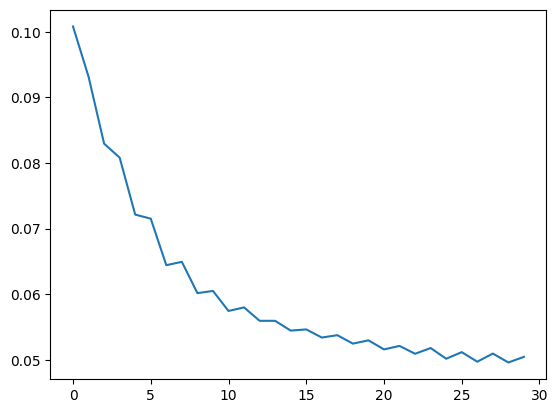

In [51]:
plt.plot(train_loss_hist)

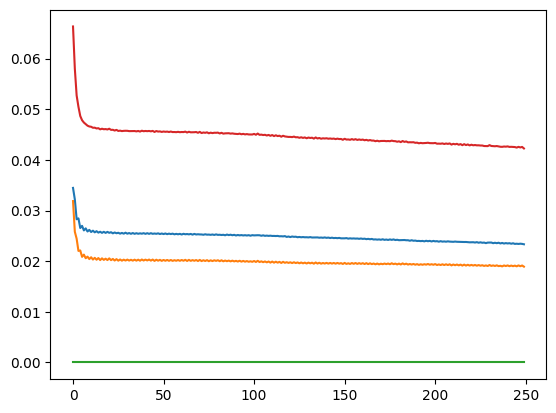

In [64]:
plt.plot(train_loss_VTC_hist)
plt.plot(train_loss_PFC_hist)
plt.plot(train_loss_class_hist)
plt.plot(train_loss_hist)

##Plotting the model

In [ ]:
!pip install netron
!pip install onnx
import torch.onnx
#import onnx

data_iterator = iter(train_dataset)
first_batch = next(data_iterator)

# The first_batch contains the first set of batches (features and labels)
VTC, PFC, Class= first_batch
# Convert to ONNX model
torch.onnx.export(model, VTC, "model.onnx", verbose=True)

# Start Netron and open the model in your browser
import netron
netron.start('model.onnx')
# Web App: Can be oppened online using Netron's web viewern
# Load the ONNX model
model = onnx.load("model.onnx")

# Check the model
onnx.checker.check_model(model)

# Print a human-readable representation of the model
print(onnx.helper.printable_graph(model.graph))

AttributeError: modules

In [ ]:
data_iterator = iter(train_dataset)
first_batch = next(data_iterator)


In [ ]:
a,b,c = first_batch

In [ ]:
a.shape

torch.Size([2401])